In [78]:
# Importing Libraries 
import ast
import pandas as pd
import seaborn as sns 
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt 

# Loading the Dataset 
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Initial Clean-up
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


In [79]:
# Countries of interest: UK, France, Netherlands, Germany, Belgium

countries = ['United Kingdom', 'France', 'Netherlands', 'Germany', 'Belgium']

# Role of interest: 'Data Analyst'

df_da_eu = df[(df['job_country'].isin(countries)) & (df['job_title_short'] == 'Data Analyst')]

# Confirmation of filters

df_da_eu['job_country'].unique().tolist()

['France', 'Germany', 'United Kingdom', 'Belgium', 'Netherlands']

In [80]:
df_da_eu['job_title_short'].unique().tolist()

['Data Analyst']

In [81]:
# Preliminary EDA

# i) count of job postings

df_plot = df_da_eu['job_country'].value_counts().head().to_frame()
df_plot

,count
job_country,
France,13803
United Kingdom,10482
Germany,7131
Netherlands,4123
Belgium,3807


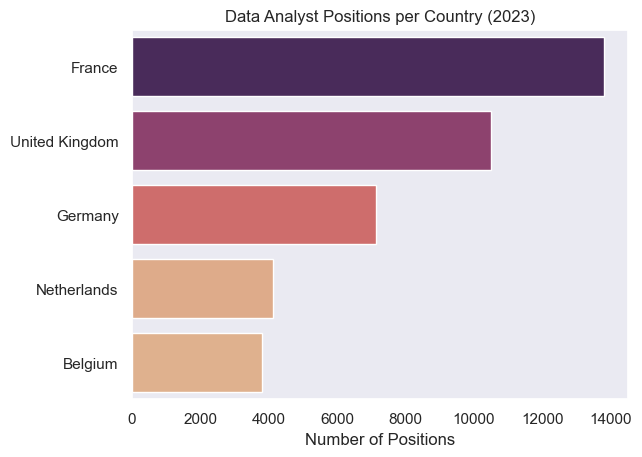

In [82]:
# A visualisation of the above data, with custom styling

sns.set_theme(style='dark')
sns.barplot(data=df_plot, 
            x='count', 
            y='job_country',
            hue='count',
            palette='flare',
            legend=False
            )

plt.title('Data Analyst Positions per Country (2023)')
plt.ylabel('')
plt.xlabel('Number of Positions')
plt.show()

In [83]:
# ii) Degree required, hybrid/remote work allowed, health insurance provided

grouped = df_da_eu.groupby('job_country')['job_no_degree_mention'].agg(['sum', 'size'])


degree_mention = (grouped['size'] - grouped['sum']).to_frame()
no_degree_mention = grouped['sum'].to_frame()
no_degree_mention


,sum
job_country,
Belgium,1439
France,3455
Germany,4883
Netherlands,2000
United Kingdom,7443


In [84]:
degree = pd.merge(degree_mention, no_degree_mention, on='job_country', how='inner')
print(degree.columns)
degree = degree.reset_index()
degree.rename(columns={0: 'degree required', 'sum':'degree not required'}, inplace=True)
degree

Index([0, 'sum'], dtype='object')


,job_country,degree required,degree not required
0,Belgium,2368,1439
1,France,10348,3455
2,Germany,2248,4883
3,Netherlands,2123,2000
4,United Kingdom,3039,7443


In [85]:
degree['total'] = degree['degree required'] + degree['degree not required']

In [86]:
degree['degree required'] = (degree['degree required'] / degree['total']) * 100

In [87]:
degree['degree not required'] = (degree['degree not required'] / degree['total']) * 100

In [88]:
degree.drop(columns='total', inplace=True)

In [89]:
degree = degree.sort_values(by='degree required', ascending=False)


In [90]:
degree

,job_country,degree required,degree not required
1,France,74.969210,25.030790
0,Belgium,62.201208,37.798792
3,Netherlands,51.491632,48.508368
2,Germany,31.524330,68.475670
4,United Kingdom,28.992559,71.007441


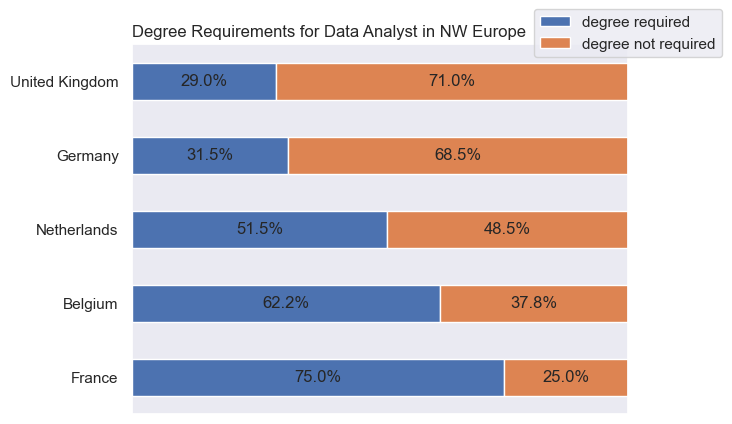

In [91]:
degree.plot(
    x = 'job_country',
    kind = 'barh',
    stacked = True,
    mark_right = True)

plt.ylabel('')
plt.xlabel('')
plt.xlim((0, 100))
plt.title('Degree Requirements for Data Analyst in NW Europe', loc='left')
plt.legend(bbox_to_anchor=(1, 1.03), loc='center')
plt.gca().set_xticks([])


df_total = degree["degree required"] + degree["degree not required"]
df_rel = degree[degree.columns[1:]].div(df_total, 0)*100
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(degree.iloc[:, 1:].cumsum(1)[n], 
                                         degree[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'center')

In [ ]:
# One could also have the same information in the more traditional piechart format. 

dict_cont_col = {
    'Belgium': {
        'job_no_degree_mention': 'Degree Required?'
    },
    'France': {
        'job_no_degree_mention': 'Degree Required?'
    },
    'Germany': {
        'job_no_degree_mention': 'Degree Required?'
    },
    'Netherlands': {
        'job_no_degree_mention': 'Degree Required?'
    },
    'United Kingdom': {
        'job_no_degree_mention': 'Degree Required?'
    }
}

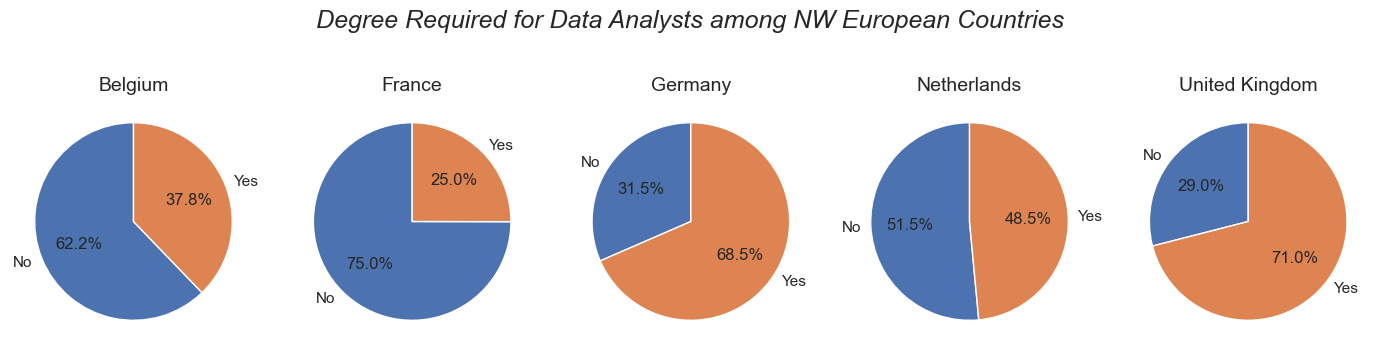

In [94]:
fig, ax = plt.subplots(1, 5, figsize=(14,4))  # Create a 1x5 grid of subplots
axes = ax.flatten()

i = 0
for country, col_dict in dict_cont_col.items():
    for column, title in col_dict.items():

        data = df_da_eu[df_da_eu['job_country'] == country][column].dropna().value_counts()
        data = data.reindex([False, True], fill_value=0)
        
        axes[i].pie(data,
                  labels=['No', 'Yes'],
                  autopct='%1.1f%%',
                  startangle=90,
                  )
        axes[i].set_title(f"{country}", fontsize=14)
        i += 1

plt.suptitle('Degree Required for Data Analysts among NW European Countries', fontsize=18, fontstyle='italic')
plt.tight_layout()
plt.show()

In [95]:
df_bar_plot = df_da_eu['company_name'].value_counts().head(10).to_frame()
df_bar_plot

,count
company_name,
OpenClassrooms,205
Harnham,199
Carrefour,192
Michael Page,173
Jobleads-UK,171
ClickJobs.io,155
Baltic Training Services Limited,134
Eyetech Solutions,114
Société Générale,103


/var/folders/lr/_5kynh2n2_lb8887_vx6z0mc0000gn/T/ipykernel_56919/2696562986.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


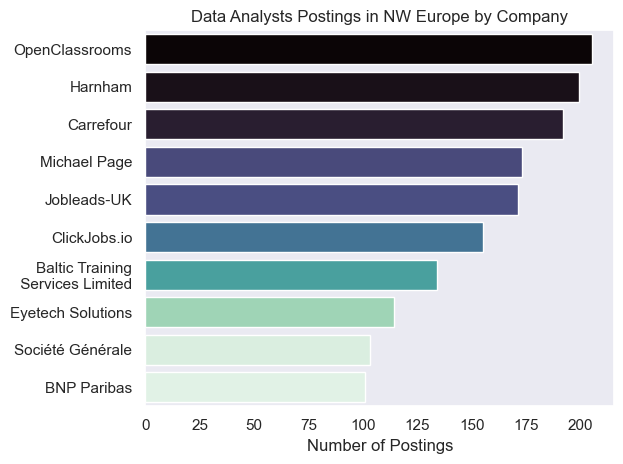

In [99]:
sns.set_theme(style='dark')
ax = sns.barplot(data=df_bar_plot, 
            x='count', 
            y='company_name', 
            hue='count', 
            palette='mako_r', 
            legend=False
            )

# Upon inspection, one of the company names is too long. The following code edits the label for the yaxis, leaving the underlying dataframe unaltered. 

labels = [label.get_text() for label in ax.get_yticklabels()]
labels = [label.replace('Baltic Training Services Limited', 'Baltic Training\n Services Limited') for label in labels]
ax.set_yticklabels(labels)

plt.title('Data Analysts Postings in NW Europe by Company')
plt.xlabel('Number of Postings')
plt.ylabel('')
plt.tight_layout()
plt.show()